In [1]:
#=== Set the directories

prof_dir = '/home/riccardo/Tesi/Data/25_a1413_merge/pyproffit'

image_dir = '../images/'
out_dir = '../profiles/'

image = '/image.fits'
expo = '/expo_map.fits'
bkg = '/bkg.fits'

regfile = '../wavdetect/reg_ds9.reg'

rmf_file = '/home/riccardo/Software/SIXTE/share/sixte/instruments/athena-wfi/wfi_w_filter_15row/athena_wfi_sixte_v20150504.rmf'
arf_file = '/home/riccardo/Software/SIXTE/share/sixte/instruments/athena-wfi/wfi_w_filter_15row/athena_sixte_wfi_w_filter_v20190122.arf'

#rsp_file = '/home/riccardo/Tesi/Data/results/M2.rsp'

#a1413
z = 0.14360
kt = 7.
nh = 0.0181

#elow e ehigh fanno riferimento alla banda dell'immagine in input
elow = 0.7
ehigh = 2.5

In [2]:
#Controlla sempre di non averlo lanciato in un terminale con ciao, 
#perché gli fa cercare i pacchetti python in altre cartelel
#! pip show scipy

In [3]:
import numpy as np
import pyproffit
import matplotlib.pyplot as plt
import os
import hydromass
import pymc3 as pm
from astropy.io import fits

from pylab import rcParams
rcParams['figure.figsize'] = 9, 9

In [4]:
os.chdir(prof_dir)
os.listdir(prof_dir)

['commands.xcm',
 'athena_wfi_sixte_v20150504.fak',
 'TAbval.txt',
 'mhyd',
 'sim.txt',
 'lumin.txt']

In [5]:
regfile = prof_dir + "/../wavdetect/reg_ds9.reg"

#The images are loaded into the _Data_ structure
datv=pyproffit.Data(imglink=image_dir+image,explink=image_dir+expo,
                   bkglink=image_dir+bkg)
datv.pixsize = 0.0372422591317446
datv.region(regfile)

Excluded 66 sources


# Sx Profile Object

Determining X-ray peak
Coordinates of surface-brightness peak: 534.0 390.0
Corresponding FK5 coordinates:  178.82498580965498 23.404857356050478
Unknown binning option lin, reverting to linear
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 158.2                      │              Nfcn = 19               │
│ EDM = 8.93e-10 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬───────────

/home/riccardo/.local/lib/python3.8/site-packages/pyproffit/profextract.py:945: RuntimeWarning: divide by zero encountered in true_divide
  chi = (self.profile-tmod)/self.eprof
<ipython-input-6-aab11b05ab74>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(out_dir+'/Sx+model.jpg', overwrite=True)


<Figure size 648x648 with 0 Axes>

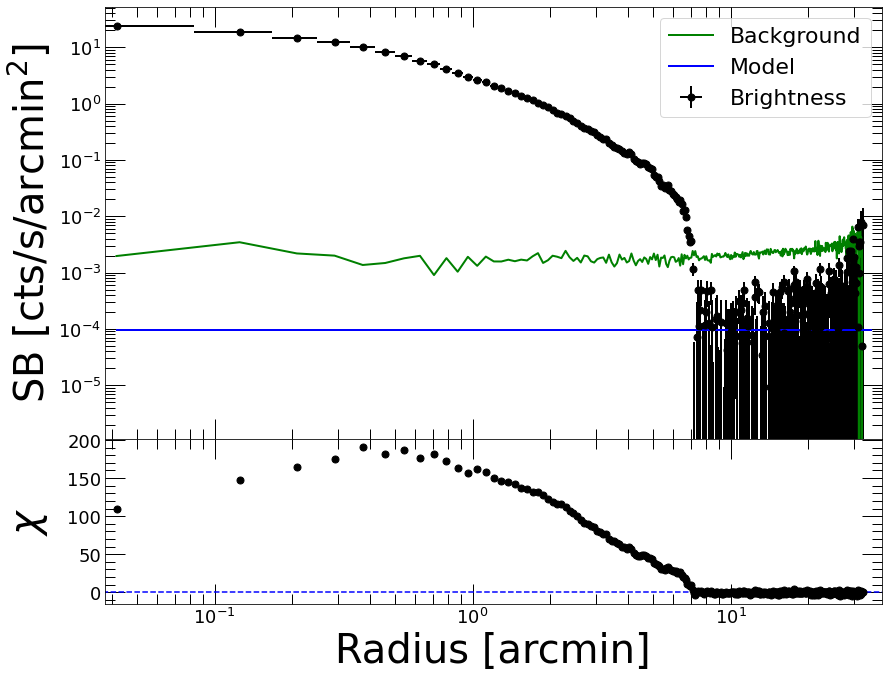

In [6]:
#Now we define a Profile object and fit the background with a constant.

prof=pyproffit.Profile(datv,center_choice='peak',maxrad=35.,binsize=5.,binning='lin')

prof.maxrad=np.abs(35.)
prof.SBprofile()

mod = pyproffit.Model(pyproffit.Const)
fitter = pyproffit.Fitter(model=mod, profile=prof,bkg=-4,method='cstat',fitlow=15.,fithigh=20.)
fitter.Migrad()

prof.Plot(model=mod)
plt.savefig(out_dir+'/Sx+model.jpg', overwrite=True)

Determining X-ray peak
Coordinates of surface-brightness peak: 534.0 390.0
Corresponding FK5 coordinates:  178.82498580965498 23.404857356050478


<ipython-input-7-e74b30844f82>:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(out_dir+'/Sx_sub.jpg', overwrite=True)


<Figure size 648x648 with 0 Axes>

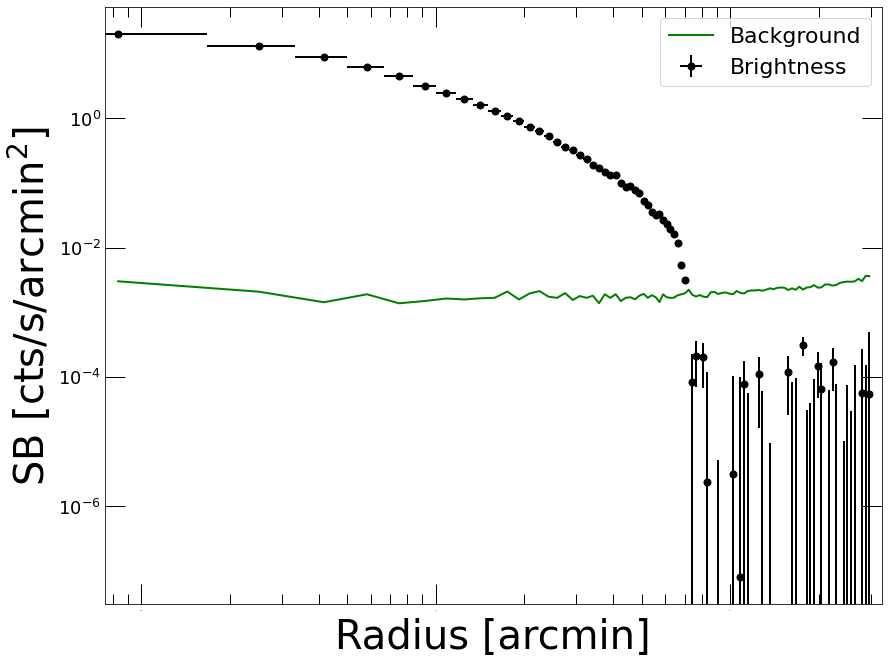

In [7]:
p2=pyproffit.Profile(datv,center_choice='peak',maxrad=30.,binsize=10.,binning='log')

#p2.MedianSB()
p2.maxrad=np.abs(30.)
p2.SBprofile()
p2.Backsub(fitter)

p2.Plot()
plt.savefig(out_dir+'/Sx_sub.jpg', overwrite=True)

In [8]:
#p2.profile = p2.profile*0.01
#print(p2.profile)
#p2.bkgprof = p2.bkgprof*0.01

# T(r)

In [9]:
#Per maggiore coerenza interna questo andrà fatto combaciare con modello per carc cxo (0.3-0.7-70)
#print(pyproffit.cosmo)

In [10]:
Tfile = np.loadtxt(open("TAbval.txt"))
Rin = Tfile[:,0]*60
Rout = Tfile[:,1]*60

radii = (Rin + Rout)/2

Tval = Tfile[:,2]
Terrsx = Tfile[:,3]
Terrdx = Tfile[:,4]

Abval =  Tfile[:,5]
Aberrsx =  Tfile[:,6]
Aberrdx =  Tfile[:,7]

<ipython-input-11-26634c6fae7e>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(out_dir+'TAbprof.jpg', overwrite=True)


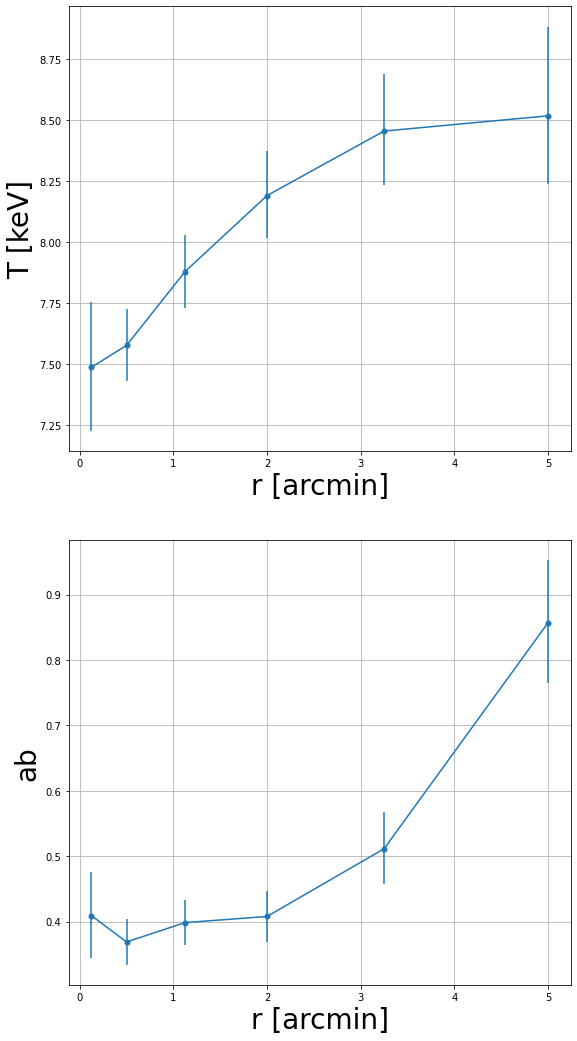

In [11]:
fig, axs = plt.subplots(2,figsize=(9, 18))

Aberrorbars = [Abval-Aberrsx, Aberrdx-Abval]
Terrorbars = [Tval-Terrsx, Terrdx-Tval]

axs[0].errorbar(radii,Tval,yerr=Terrorbars,marker='.',ms=10)
axs[0].grid()

axs[1].errorbar(radii,Abval,yerr=Aberrorbars,marker='.',ms=10)
axs[1].grid()

axs[0].set_xlabel("r [arcmin]", fontsize=28)
axs[0].set_ylabel("T [keV]", fontsize=28)

axs[1].set_xlabel("r [arcmin]", fontsize=28)
axs[1].set_ylabel("ab", fontsize=28)

plt.savefig(out_dir+'TAbprof.jpg', overwrite=True)
plt.show()

# Model the PSF

In [12]:
def fking(x):
    r0=0.0883981
    alpha=1.58918
    return np.power(1.+(x/r0)**2,-alpha)

p2.PSF(psffunc=fking)

In [13]:
#se si usa rsp invece di rmf+arf sostituire quei parametri con
#                   rmf = rsp_file
#                   rmf=rmf_file,
#                   arf=arf_file,


cf = p2.Emissivity(z=z,
                   kt=kt,
                   nh=nh,
                   elow=elow,
                   rmf=rmf_file,
                   arf=arf_file,
                   ehigh=ehigh)

print(cf)

2398.0


# Mass Model Object (Hydromass.Model class)

In [14]:
from astropy.cosmology import FlatLambdaCDM
cosmo_mio = FlatLambdaCDM(H0=70, Om0=0.3)

In [15]:
spec_data = hydromass.SpecData(redshift=z, rin=Rin, rout=Rout, kt=Tval, err_kt_low=Tval-Terrsx,\
                               err_kt_high=Terrdx-Tval)

spec_data.PSF(pixsize=2.5/60., psffunc=fking)

tmhyd = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z, 
                       cosmo=cosmo_mio)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 680.005 Mpc
At the redshift of the source 1 arcmin is 151.248 kpc


In [16]:
#Credo diagnostica?
'''print(np.median(tmhyd.samppar[:,0]))
print(np.median(tmhyd.samppar[:,1]))

plt.plot(tmhyd.samppar[:,1], tmhyd.samppar[:,0], 'o')
plt.show()

plt.plot(np.arange(1,len(tmhyd.samppar[:,1])+1,1), tmhyd.samppar[:,1])
plt.show()'''

"print(np.median(tmhyd.samppar[:,0]))\nprint(np.median(tmhyd.samppar[:,1]))\n\nplt.plot(tmhyd.samppar[:,1], tmhyd.samppar[:,0], 'o')\nplt.show()\n\nplt.plot(np.arange(1,len(tmhyd.samppar[:,1])+1,1), tmhyd.samppar[:,1])\nplt.show()"

## Forward modeling (Deproiezione)

In [17]:
mforw = hydromass.Mhyd(sbprofile=p2, 
                        spec_data=spec_data, 
                        redshift=z, 
                        cosmo=cosmo_mio)

modforw = hydromass.Forward(fix=[False, False, False, False, False])
#modforw = hydromass.Forward()

mforw.emissivity(nh=nh, rmf=rmf_file, arf=arf_file, elow=elow, ehigh=ehigh)
#mforw.emissivity(nh=nh, rmf=rsp_file, elow=0.7, ehigh=1.2)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 680.005 Mpc
At the redshift of the source 1 arcmin is 151.248 kpc
Mean cluster temperature: 7.9221680234608245  keV


In [18]:
mforw.run_forward(modforw,nmcmc=1000, tune=100)

coefs -540.2245713326936
p0_interval__ -0.08490196666224548


/home/riccardo/.local/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


c500_interval__ -15.980740195062477
gamma_interval__ -3.0729194119118515
alpha_interval__ -0.9338699254892735
beta_interval__ -1.1138006205343867
Running MCMC...


/home/riccardo/.local/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/riccardo/.local/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/riccardo/.local/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


/home/riccardo/.local/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.8/dist-packages/hydromass-0.1-py3.8.egg/hydromass/forward.py:658: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(nmcmc, start=start, tune=tune)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/riccardo/.local/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, gamma, c500, p0, coefs]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 277 seconds.
The acceptance probability does not match the target. It is 0.9103569829845467, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9219318338812769, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Done.
 Total computing time is:  4.985694523652395  minutes


<Figure size 648x648 with 0 Axes>

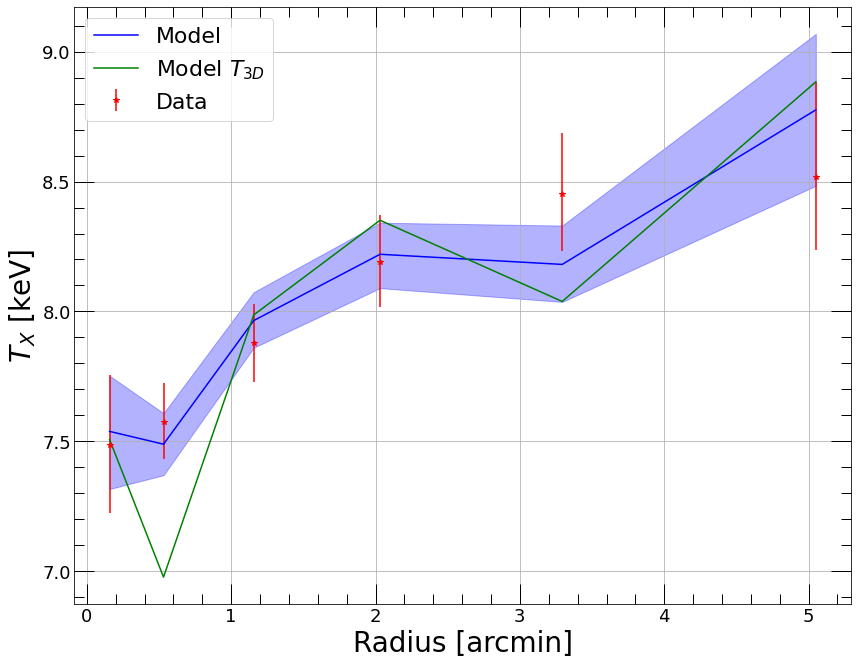

In [19]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.grid()

plt.errorbar(spec_data.rref_x_am,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(spec_data.rref_x_am,mforw.ktmod,color='blue', label='Model')
plt.fill_between(spec_data.rref_x_am, mforw.ktmod_lo, mforw.ktmod_hi, color='blue', alpha=0.3)

plt.plot(spec_data.rref_x_am,mforw.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)
plt.savefig(out_dir+"Tx_for.jpg")

In [20]:
#print(res_forw)

<Figure size 936x720 with 0 Axes>

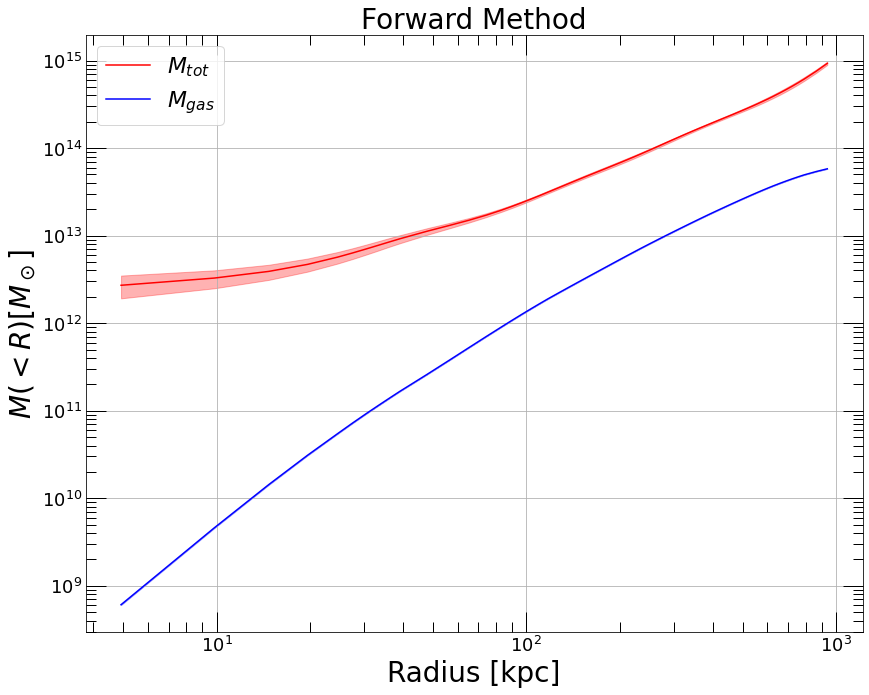

In [21]:
res_forw, fig = hydromass.mass_forw_from_samples(mforw, modforw, plot=True)

plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.title("Forward Method", fontsize=28)
plt.grid()

plt.plot(res_forw['R_OUT'], res_forw['MASS'], color='red', label=r'$M_{tot}$')
plt.fill_between(res_forw['R_OUT'], res_forw['MASS_LO'], res_forw['MASS_HI'], color='red', alpha=0.3)

plt.plot(res_forw['R_OUT'], res_forw['MGAS'], color='blue', label=r'$M_{gas}$')
#ci sono le bande di errore sulla mgas, ma non si vedono (se fai mgashi*1e2 e mgaslow/1e2 le vedi)
plt.fill_between(res_forw['R_OUT'], res_forw['MGAS_LO'], res_forw['MGAS_HI'], color='blue', alpha=0.3)

plt.legend(fontsize=22)
plt.savefig(out_dir+'comp_forw.jpg')

In [22]:
#Diagnostica del montecarlo?
'''pm.traceplot(mforw.trace, var_names=['p0','c500','gamma','alpha','beta'])
plt.show()'''

"pm.traceplot(mforw.trace, var_names=['p0','c500','gamma','alpha','beta'])\nplt.show()"

# Confronto con risultati CXO

In [23]:
cxo_dir="../cxo/"

cxo_dens = fits.open(cxo_dir+"densprof.fits")
cxo_dens = cxo_dens[1].data

cxo_kt = fits.open(cxo_dir+"ktprof.fits")
cxo_kt = cxo_kt[1].data

cxo_ktraw = fits.open(cxo_dir+"ktrawprof.fits")
cxo_ktraw = cxo_ktraw[1].data

cxo_mass = fits.open(cxo_dir+"massprof.fits")
cxo_mass = cxo_mass[1].data

cxo_sb = fits.open(cxo_dir+"sbprof.fits")
cxo_sb = cxo_sb[1].data

cxo_info = fits.open(cxo_dir+"global.fits")
cxo_info = cxo_info[1].data

#cxo_fits
carc = cxo_info['CARC'][0]
R500 = cxo_info['R500']
M500 = cxo_info['M500']

#hydromass
carc2 = mforw.amin2kpc

print("R500_cxo",R500)
print("carc_cxo=",carc)
print("carc_ath=",carc2)

print("R200_cxo",R500/carc)

R500_cxo [1269.83051684]
carc_cxo= 151.24806383261455
carc_ath= 151.2480598429345
R200_cxo [8.39568114]


<Figure size 648x648 with 0 Axes>

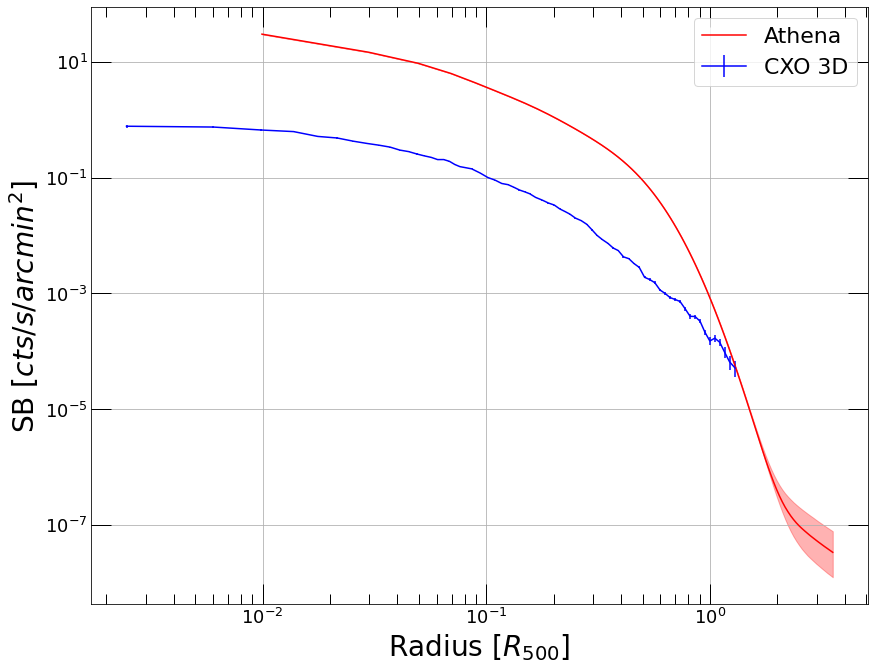

In [24]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius $[R_{500}]$', fontsize=28)
plt.ylabel('SB $[cts/s/arcmin^2]$', fontsize=28)
plt.grid()

plt.errorbar(cxo_sb['RW'][0,:]/R500, cxo_sb['SB'][0,:],cxo_sb['SBERR'][0,:], color='blue', label='CXO 3D')

check = np.array([len(p2.bins),len(mforw.sb)])
l=np.min(check)

plt.plot(p2.bins[:l]/R500*carc2,mforw.sb[:l],label='Athena',color='red')
plt.fill_between(p2.bins[:l]/R500*carc2, mforw.sb_hi[:l], mforw.sb_lo[:l], color='red', alpha=0.3)

plt.legend(fontsize=22)
plt.savefig(out_dir+'cxo_sb.jpg')

<Figure size 648x648 with 0 Axes>

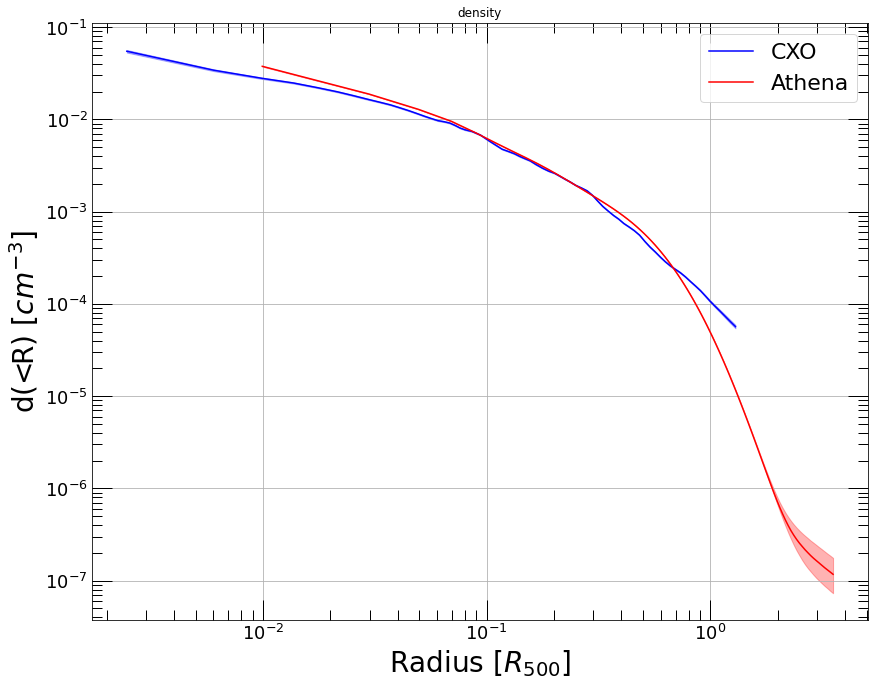

In [25]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.title('density')
plt.xlabel('Radius $[R_{500}]$', fontsize=28)
plt.ylabel(r'd(<R) $[cm^{-3}]$', fontsize=28)
plt.grid()

plt.plot(cxo_dens['RW'][0,:]/R500, cxo_dens['DENS'][0,:],color='blue', label='CXO')
plt.fill_between(cxo_dens['RW'][0,:]/R500, cxo_dens['DENS'][0,:]-cxo_dens['MDENS'][0,:], cxo_dens['DENS'][0,:]+cxo_dens['PDENS'][0,:], color='blue', alpha=0.3)

check = np.array([len(p2.bins),len(mforw.dens)])
l=np.min(check)

plt.plot(p2.bins[:l]/R500*carc2,mforw.dens[:l],label='Athena',color='red')
plt.fill_between(p2.bins[:l]/R500*carc2, mforw.dens_hi[:l], mforw.dens_lo[:l], color='red', alpha=0.3)

plt.legend(fontsize=22)
plt.savefig(out_dir+'cxo_dens.jpg')

<Figure size 648x648 with 0 Axes>

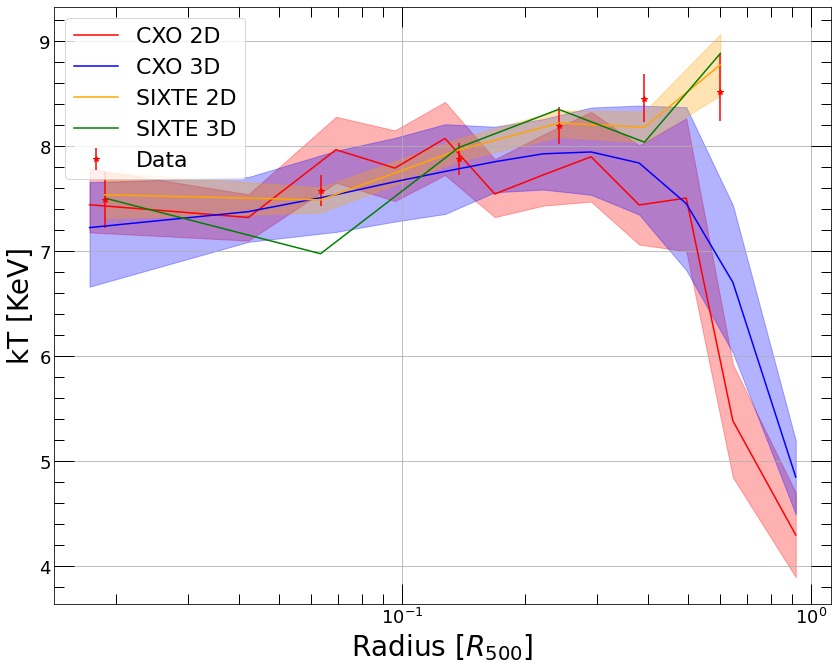

In [26]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius $[R_{500}]$', fontsize=28)
plt.ylabel('kT [KeV]', fontsize=28)
plt.grid()

plt.plot(cxo_ktraw['RW'][0,:]/R500, cxo_ktraw['T'][0,:],color='red', label='CXO 2D')
plt.fill_between(cxo_ktraw['RW'][0,:]/R500, cxo_ktraw['T'][0,:]-cxo_ktraw['MT'][0,:], cxo_ktraw['T'][0,:]+cxo_ktraw['PT'][0,:], color='red', alpha=0.3)

plt.plot(cxo_kt['RW'][0,:]/R500, cxo_kt['T'][0,:],color='blue', label='CXO 3D')
plt.fill_between(cxo_kt['RW'][0,:]/R500, cxo_kt['T'][0,:]-cxo_kt['MT'][0,:], cxo_kt['T'][0,:]+cxo_kt['PT'][0,:], color='blue', alpha=0.3)

plt.errorbar(spec_data.rref_x_am*carc2/R500,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(spec_data.rref_x_am*carc2/R500,mforw.ktmod,color='orange', label='SIXTE 2D')
plt.fill_between(spec_data.rref_x_am*carc2/R500, mforw.ktmod_lo, mforw.ktmod_hi, color='orange', alpha=0.3)

plt.plot(spec_data.rref_x_am*carc2/R500,mforw.kt3d,color='green', label='SIXTE 3D')

plt.legend(fontsize=22)
plt.savefig(out_dir+'cxo_temp.jpg')

In [27]:
print (R500,carc,R500/carc,R500/carc2)

[1269.83051684] 151.24806383261455 [8.39568114] [8.39568136]


<Figure size 648x648 with 0 Axes>

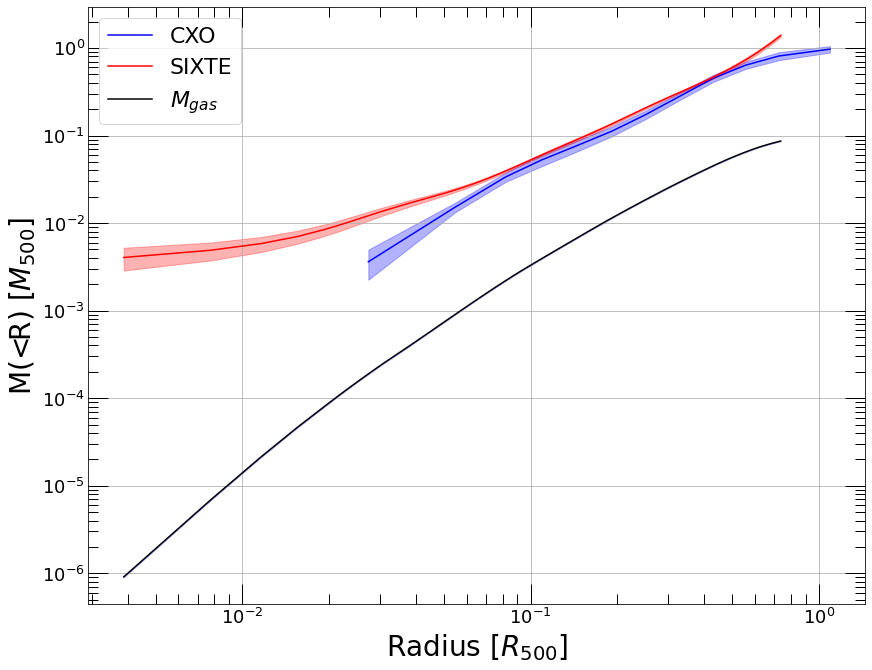

In [28]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius $[R_{500}]$', fontsize=28)
plt.ylabel(r'M(<R) $[M_{500}]$', fontsize=28)
plt.grid()

plt.plot(cxo_mass['ROUT'][0,:]/R500, cxo_mass['M'][0,:]/M500,color='blue', label='CXO')
plt.fill_between(cxo_mass['ROUT'][0,:]/R500, (cxo_mass['M'][0,:]-cxo_mass['MM'][0,:])/M500,\
                 (cxo_mass['M'][0,:]+cxo_mass['PM'][0,:])/M500, color='blue', alpha=0.3)

plt.plot(res_forw['R_OUT']/R500, res_forw['MASS']/M500, color='red', label='SIXTE')
plt.fill_between(res_forw['R_OUT']/R500, res_forw['MASS_LO']/M500, res_forw['MASS_HI']/M500,\
                 color='red', alpha=0.3)

plt.plot(res_forw['R_OUT']/R500, res_forw['MGAS']/M500, color='black', label=r'$M_{gas}$')
#ci sono le bande di errore sulla mgas, ma non si vedono (se fai mgashi*1e2 e mgaslow/1e2 le vedi)
plt.fill_between(res_forw['R_OUT']/R500, res_forw['MGAS_LO']/M500, res_forw['MGAS_HI']/M500,\
                 color='blue', alpha=0.3)

plt.legend(fontsize=22)
plt.savefig(out_dir+'cxo_mass.jpg')

# Ratios
## Mass

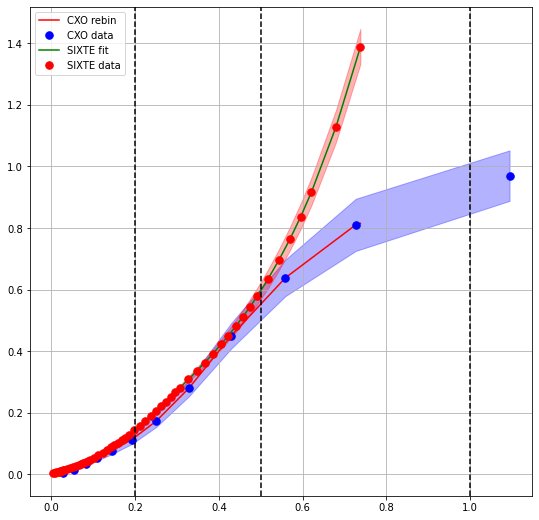

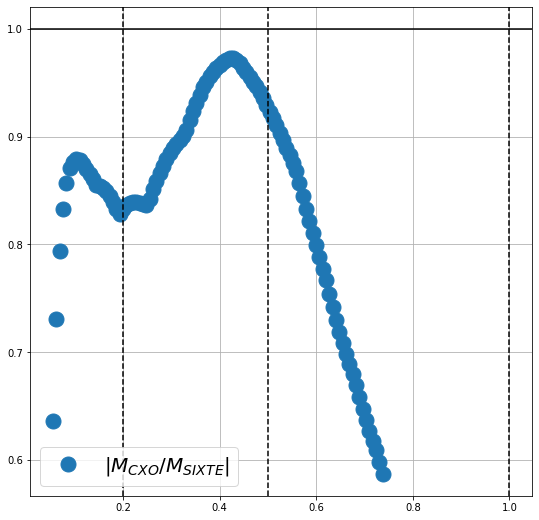

In [29]:
from scipy.interpolate import interp1d

x_min = np.max([cxo_mass['ROUT'][0,1]/R500, res_forw['R_OUT'][1]/R500])
x_max = np.min([cxo_mass['ROUT'][0,-1]/R500, res_forw['R_OUT'][-1]/R500])

x_ratio = np.linspace(x_min, x_max, num=100)

f_cxo1 = interp1d(cxo_mass['ROUT'][0,:]/R500, cxo_mass['M'][0,:]/M500)

plt.plot(x_ratio, f_cxo1(x_ratio), 'r-', label='CXO rebin')
plt.plot(cxo_mass['ROUT'][0,:]/R500, cxo_mass['M'][0,:]/M500, 'b.', ms=15, label='CXO data')
plt.fill_between(cxo_mass['ROUT'][0,:]/R500, (cxo_mass['M'][0,:]-cxo_mass['MM'][0,:])/M500,\
                 (cxo_mass['M'][0,:]+cxo_mass['PM'][0,:])/M500, color='b', alpha=0.3)

f_six1 = interp1d(res_forw['R_OUT']/R500, res_forw['MASS']/M500)

plt.plot(x_ratio, f_six1(x_ratio), 'g-', label='SIXTE fit')
plt.plot(res_forw['R_OUT']/R500, res_forw['MASS']/M500, 'r.', ms=15, label='SIXTE data')
plt.fill_between(res_forw['R_OUT']/R500, res_forw['MASS_LO']/M500, res_forw['MASS_HI']/M500,\
                 color='red', alpha=0.3)

plt.axvline(x=0.2, color='k', linestyle='--')
plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')

plt.legend()
plt.grid()
plt.show()
plt.close()

ratio = np.abs(f_cxo1(x_ratio) / f_six1(x_ratio))
plt.plot(x_ratio, ratio, '.', ms=30, label=r'$\vert M_{CXO}/M_{SIXTE}\vert$')

plt.axhline(y=1, color='k', linestyle='-')
plt.axvline(x=0.2, color='k', linestyle='--')
plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')

plt.legend(fontsize='20')
plt.grid()
plt.savefig(out_dir+'mass_ratio.jpg')
plt.show()
plt.close()

In [30]:
#Saving output to a txt file for comparison plot
mass_ratio_file = open(out_dir+'mass_ratio_a1413.txt', 'w')

mass_ratio_file.write('#Radii [R500]\n')
mass_ratio_file.write(np.str(list(x_ratio)))
mass_ratio_file.write('\n#Mass ratio\n')
mass_ratio_file.write(np.str(list(ratio)))
## Density
mass_ratio_file.close()

## Density

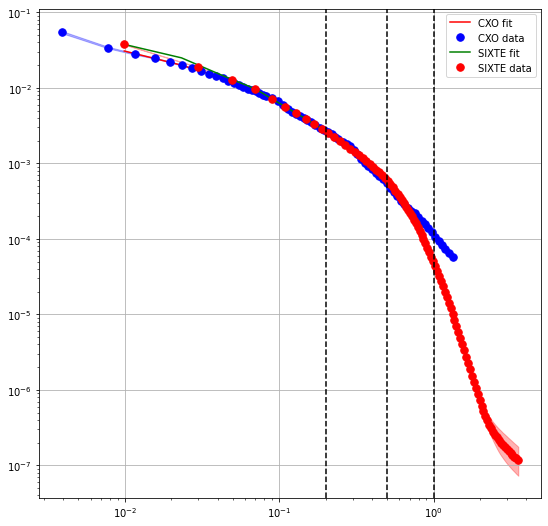

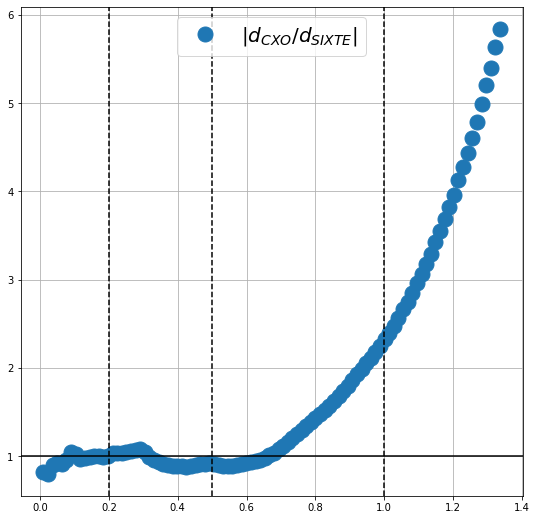

In [31]:
check = np.array([len(p2.bins),len(mforw.dens)])
l=np.min(check)

x_min = np.max([cxo_dens['ROUT'][0,1]/R500, p2.bins[0]/R500*carc2])
x_max = np.min([cxo_dens['ROUT'][0,-1]/R500, p2.bins[l-1]/R500*carc2])

x_ratio = np.linspace(x_min, x_max, num=100)

f_cxo1 = interp1d(cxo_dens['ROUT'][0,:]/R500, cxo_dens['DENS'][0,:])
plt.plot(x_ratio, f_cxo1(x_ratio), 'r-', label='CXO fit')

plt.plot(cxo_dens['ROUT'][0,:]/R500, cxo_dens['DENS'][0,:], 'b.', ms=15, label='CXO data')
plt.fill_between(cxo_dens['ROUT'][0,:]/R500, (cxo_dens['DENS'][0,:]-cxo_dens['MDENS'][0,:]),\
                 (cxo_dens['DENS'][0,:]+cxo_dens['PDENS'][0,:]), color='b', alpha=0.3)

f_six1 = interp1d(p2.bins[:l]/R500*carc2, mforw.dens[0:])

plt.plot(x_ratio, f_six1(x_ratio), 'g-', label='SIXTE fit')
plt.plot(p2.bins[:l]/R500*carc2, mforw.dens[0:], 'r.', ms=15, label='SIXTE data')
plt.fill_between(p2.bins[:l]/R500*carc2, mforw.dens_lo[0:], mforw.dens_hi[0:],\
                 color='red', alpha=0.3)

plt.axvline(x=0.2, color='k', linestyle='--')
plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')

plt.legend()
plt.loglog()
plt.grid()
plt.show()
plt.close()

ratio = np.abs(f_cxo1(x_ratio) / f_six1(x_ratio))
plt.plot(x_ratio, ratio, '.', ms=30, label=r'$\vert d_{CXO}/d_{SIXTE}\vert$')

plt.axhline(y=1, color='k', linestyle='-')
plt.axvline(x=0.2, color='k', linestyle='--')
plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')

plt.legend(fontsize='20')
plt.grid()
plt.savefig(out_dir+'dens_ratio.jpg')
plt.show()
plt.close()

In [32]:
#Saving output to a txt file for comparison plot
mass_ratio_file = open(out_dir+'dens_ratio_a1413.txt', 'w')

mass_ratio_file.write('#Radii [R500]\n')
mass_ratio_file.write(np.str(list(x_ratio)))
mass_ratio_file.write('\n#Dens ratio\n')
mass_ratio_file.write(np.str(list(ratio)))

mass_ratio_file.close()

## kT

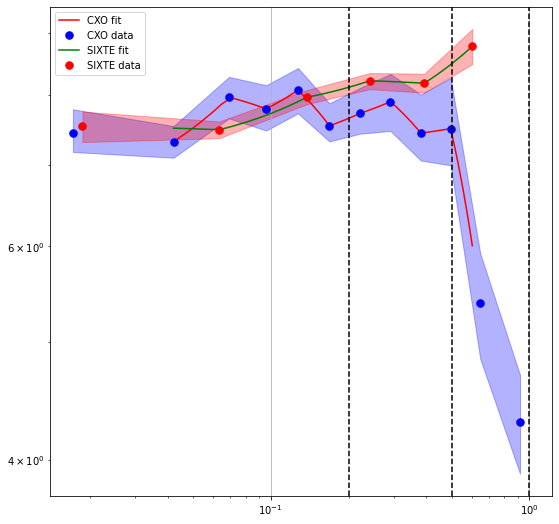

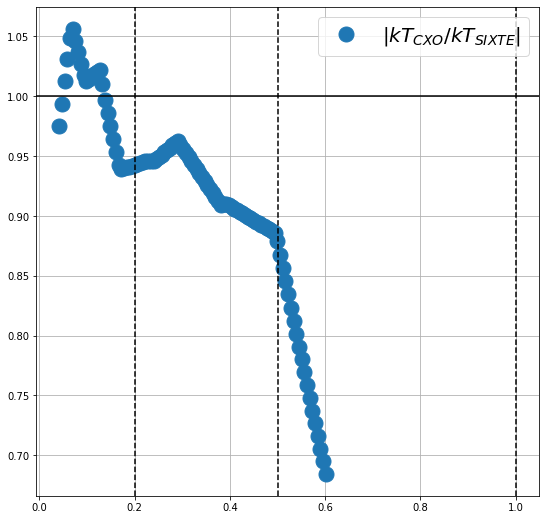

In [33]:
x_min = np.max([cxo_ktraw['RW'][0,1]/R500, spec_data.rref_x_am[0]*carc2/R500])
x_max = np.min([cxo_ktraw['RW'][0,-1]/R500, spec_data.rref_x_am[-1]*carc2/R500])

x_ratio = np.linspace(x_min, x_max, num=100)

f_cxo1 = interp1d(cxo_ktraw['RW'][0,:]/R500, cxo_ktraw['T'][0,:])
plt.plot(x_ratio, f_cxo1(x_ratio), 'r-', label='CXO fit')

plt.plot(cxo_ktraw['RW'][0,:]/R500, cxo_ktraw['T'][0,:], 'b.', ms=15, label='CXO data')
plt.fill_between(cxo_ktraw['RW'][0,:]/R500, (cxo_ktraw['T'][0,:]-cxo_ktraw['MT'][0,:]),\
                 (cxo_ktraw['T'][0,:]+cxo_ktraw['PT'][0,:]), color='b', alpha=0.3)

f_six1 = interp1d(spec_data.rref_x_am[:]*carc2/R500, mforw.ktmod[:])
plt.plot(x_ratio, f_six1(x_ratio), 'g-', label='SIXTE fit')

plt.plot(spec_data.rref_x_am[:]*carc2/R500, mforw.ktmod[:], 'r.', ms=15, label='SIXTE data')
plt.fill_between(spec_data.rref_x_am[:]*carc2/R500, mforw.ktmod_lo[:], mforw.ktmod_hi[:],\
                 color='red', alpha=0.3)

plt.axvline(x=0.2, color='k', linestyle='--')
plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')

plt.legend()
plt.loglog()
plt.grid()
plt.show()
plt.close()

ratio = np.abs(f_cxo1(x_ratio) / f_six1(x_ratio))
plt.plot(x_ratio, ratio, '.', ms=30, label=r'$\vert kT_{CXO}/kT_{SIXTE}\vert$')

plt.axhline(y=1, color='k', linestyle='-')
plt.axvline(x=0.2, color='k', linestyle='--')
plt.axvline(x=0.5, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')

plt.legend(fontsize='20')
plt.grid()
plt.savefig(out_dir+'kT_ratio.jpg')
plt.show()
plt.close()

In [34]:
#Saving output to a txt file for comparison plot
mass_ratio_file = open(out_dir+'kt_ratio_a1413.txt', 'w')

mass_ratio_file.write('#Radii [R500]\n')
mass_ratio_file.write(np.str(list(x_ratio)))
mass_ratio_file.write('\n#kT ratio\n')
mass_ratio_file.write(np.str(list(ratio)))

mass_ratio_file.close()